# How Many Fingers? - PyTorch

In this replository is a small application that uses a CNN to predict how many figers you are holding up. The application does some small image manipulation to extract the edges of your hand against a plain background. It also offers functionality to collect data for training.

Data has been collected within the application by holding up 0 to 5 fingers in the region of interest and recording images. For training ~1500 images of each case has been recorded with an additional ~600 images for validation.

In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from pytorch_model_summary import summary
import time
import os
import copy

# plot figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

In [2]:
DATA_PATH = './images/'
BATCH_SIZE = 128
NUM_WORKERS = 4 # number of cores

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(300),
        transforms.RandomRotation(10),
        transforms.RandomAffine(degrees=0, translate=(0.1 ,0.1)),
        transforms.RandomAffine(degrees=0, scale=(.8, 1)),
        transforms.RandomHorizontalFlip(),
        transforms.Grayscale(),
        transforms.ToTensor(),
        transforms.Normalize((0.5,),(0.5,))
    ]),
    'test': transforms.Compose([
        transforms.Resize(300),
        transforms.Grayscale(),
        transforms.ToTensor(),
        transforms.Normalize((0.5,),(0.5,))
    ]),
}

image_datasets = {x: datasets.ImageFolder(os.path.join(DATA_PATH, x),
                                          data_transforms[x])
                  for x in ['train', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=BATCH_SIZE,
                                             shuffle=True, num_workers=NUM_WORKERS)
              for x in ['train', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}

class_names = image_datasets['train'].classes

In [3]:
print("Classes: ", class_names)
print("Number of train samples: ", len(image_datasets['train']))
print("Number of test/validation samples: ", len(image_datasets['val']))
print("# of training batches (steps per epoch): ", len(dataloaders['train']))
print("# of validation batches (validation steps): ", len(dataloaders['val']))

Classes:  ['FIVE', 'FOUR', 'NONE', 'ONE', 'THREE', 'TWO']
Number of train samples:  9081
Number of test/validation samples:  3632
# of training batches (steps per epoch):  71
# of validation batches (validation steps):  29


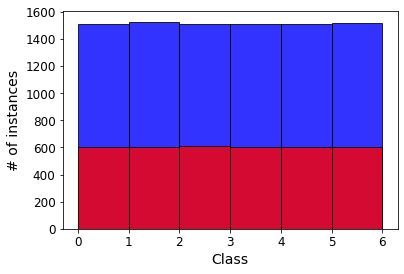

In [4]:
h1,_,_ = plt.hist(np.array(image_datasets['train'].targets), bins=range(0,7), alpha=0.8, color='blue', edgecolor='black')
h2,_,_ = plt.hist(np.array(image_datasets['val'].targets),  bins=range(0,7), alpha=0.8, color='red', edgecolor='black')
plt.ylabel('# of instances')
plt.xlabel('Class');

torch.Size([1, 300, 300])


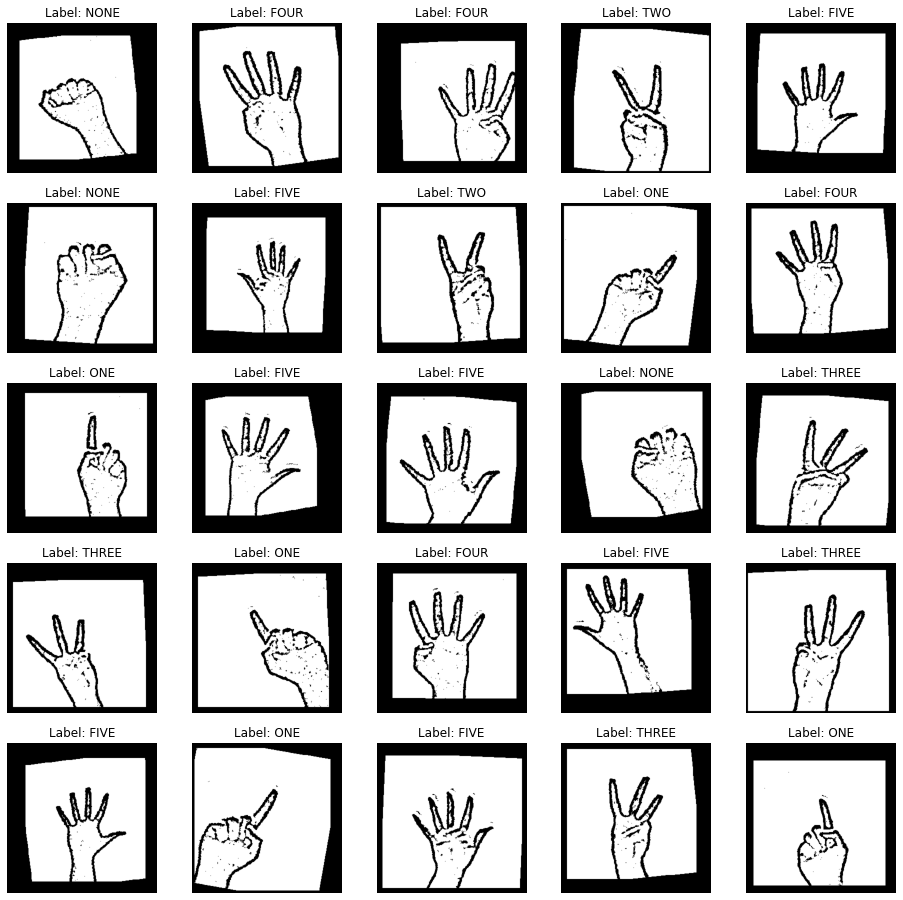

In [20]:
for batch_idx, (data, target) in enumerate(dataloaders['train']): 
    print(data[0].shape) # [Color, Height, Width]

    plt.figure(figsize=(16, 16))
    for i in range(25):
        img = data[i].permute(1, 2, 0) # rotates and transposes image tensor from [C, H, W] to get [H, W, C]
        label = target[i].item()
        plt.subplot(5,5,i+1)
        plt.axis('off')
        plt.title("Label: {}".format(class_names[label]))
        plt.imshow(img, cmap='gray')
    if batch_idx == 0: break # only see images from the first batch

Next we'll do some quick checks to make sure our data are labeled correctly

## Convolutional Neural Net

The data looks resonable so now we will define a CNN model to train and use within our application. The model below has not been thoroughly optimized but seems to perform well for our purposes.

--------------


- kernel_size =>  a 2-tuple specifying the width and height of the 2D convolution window. (A single value represents the same value for width and heigth)

***For nn.Linear you would have to provide the number if in_features first, which can be calculated using your layers and input shape or just by printing out the shape of the activation in your forward method.



In [2]:
# model with input_shape = (300, 300, 1)
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        #input_channels = 1, output channels = 6, kernel_size=(3,3)
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)
        self.pool1 = nn.MaxPool2d(2) # same as pool_size=(2,2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.pool2 = nn.MaxPool2d(2)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3)
        self.pool3 = nn.MaxPool2d(2)
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3)
        self.pool4 = nn.MaxPool2d(2)

        self.hidden= nn.Linear(128*16*16, 512) # The linear layer should therefore take 128*16*16=32768 input features
        self.drop = nn.Dropout(0.3) # 30% probability of an element to be zeroed
        self.out = nn.Linear(512, 6)

    def forward(self, x):
        x = F.relu(self.conv1(x))  # -> [batch_size, 32, 298, 298] => The 32 is given by the number of kernels your conv layer is using.
                                                                    # Since you are not using any padding and leave the stride and dilation as 1,
                                                                    # a kernel size of 3 will crop 1 pixel in each spatial dimension.
                                                                    # Therefore you’ll end up with 32 activation maps of spatial size 298x298.
        # print(x.shape)
        x = self.pool1(x) # -> [batch_size, 32, 149, 149] => The max pooling layer will halve the spatial size
        # print(x.shape)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = F.relu(self.conv3(x))
        x = self.pool3(x)
        x = F.relu(self.conv4(x))
        x = self.pool4(x)
        x = x.flatten(start_dim=1)
        #x = torch.flatten(x, start_dim=1) # Flattens a contiguous range of dims in a tensor
        #x = x.view(x.size(0), -1) # -> [batch_size, 128*16*16=32768]
        x = F.relu(self.hidden(x)) # -> [batch_size, 512]
        x = self.drop(x) # -> [batch_size, 512]
        x = self.out(x)
        x = F.softmax(x, dim=1) # -> [batch_size, 6]
        return x

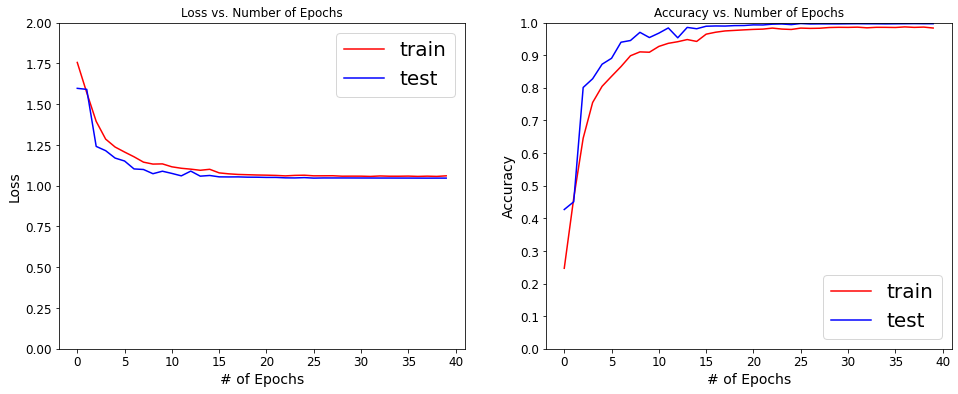

In [10]:
train_loss_hist = []
val_loss_hist = []
train_acc_hist = []
val_acc_hist = []

train_loss_hist = [h for h in loss_history['train']]
val_loss_hist = [h for h in loss_history['val']]
train_acc_hist = [h.cpu().numpy() for h in acc_history['train']]
val_acc_hist = [h.cpu().numpy() for h in acc_history['val']]

plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.title("Loss vs. Number of Epochs")
plt.xlabel("# of Epochs")
plt.ylabel("Loss")
plt.plot(range(NUM_EPOCHS), train_loss_hist,'r-', label="train")
plt.plot(range(NUM_EPOCHS), val_loss_hist,'b-', label="test")
plt.ylim((0,2))
plt.xticks(np.arange(0, NUM_EPOCHS+1, 5.0))
plt.legend(prop={'size': 20}, loc='upper right')
plt.subplot(1,2,2)
plt.title("Accuracy vs. Number of Epochs")
plt.xlabel("# of Epochs")
plt.ylabel("Accuracy")
plt.plot(range(NUM_EPOCHS), train_acc_hist,'r-', label="train")
plt.plot(range(NUM_EPOCHS), val_acc_hist,'b-', label="test")
plt.ylim((0,1.))
plt.xticks(np.arange(0, NUM_EPOCHS+1, 5.0))
plt.yticks(np.arange(0, 1.1, 0.1))
plt.legend(prop={'size': 20}, loc='lower right')
plt.show()

Since there is dropout being applied in the network and additional (random) augmentation being applied to the training set it is not surprising that the validation set is out-performing the training set. Nonetheless, it seems that in either case we're able to achieve near perfect ( > 99% ) accuracy.

This model is able to hence surpass human performance when the human is severely concussed or inebriated.

## Performance and Error Analysis

Our model is performing so well that there are not many cases where the model has failed for us to understand our model better. To try and probe a bit deeper I will expand the testing set and apply some augmentation.

In [3]:
criterion = nn.CrossEntropyLoss() # only need the loss function to evaluate model

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# PATH = './models/model_test14.pth'
PATH = 'model_test14.pth'
model = CNN()
if device == torch.device('cpu'): # load on CPU
    model.load_state_dict(torch.load(PATH, map_location=device)) # must deserialize the saved state_dict before passing
else: # load on GPU
    model.load_state_dict(torch.load(PATH))
    model.to(device)
model.eval() # set dropout and batch normalization layers to evaluation mode

CNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (hidden): Linear(in_features=32768, out_features=512, bias=True)
  (drop): Dropout(p=0.3, inplace=False)
  (out): Linear(in_features=512, out_features=6, bias=True)
)

In [4]:
DATA_PATH = './images/'
BATCH_SIZE = 128
NUM_WORKERS = 4
# augmentations adds variations to testing test to better analyze performance 
data_transforms = {
    'test': transforms.Compose([
        transforms.Resize(300),
        transforms.RandomRotation(10),
        transforms.RandomAffine(degrees=0, translate=(0.1 ,0.1)),
        transforms.RandomAffine(degrees=0, scale=(.8, 1)),
        transforms.RandomHorizontalFlip(),
        transforms.Grayscale(),
        transforms.ToTensor(),
        transforms.Normalize((0.5,),(0.5,))
    ])
}

image_datasets = {x: datasets.ImageFolder(os.path.join(DATA_PATH, x), data_transforms[x])
                  for x in ['test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
              for x in ['test']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['test']}
class_names = image_datasets['test'].classes
print("There are {} testing images beloging to {} classes.".format(len(image_datasets['test']), len(class_names)))

There are 3632 testing images beloging to 6 classes.


In [213]:
test_loss = 0.0
class_correct = list(0. for i in range(6))
class_total = list(0. for i in range(6))
incorrect_examples, incorrect_preds, incorrect_target = [], [], []

for batch_idx, (data, target) in enumerate(dataloaders['test']): # total of 29 validation batches / 'validation steps'
    data, target = data.to(device), target.to(device) # move tensors to GPU or CPU 
    output = model(data) # forward pass
    loss = criterion(output, target) # batch loss
    test_loss += loss.item() * data.size(0) # test loss update
    _, pred = torch.max(output, 1) # convert output probabilities to predicted class    
    correct_tensor = pred.eq(target.data.view_as(pred)) # compare predictions to true label
    correct = np.squeeze(correct_tensor.numpy()) if not torch.cuda.is_available() else np.squeeze(correct_tensor.cpu().numpy())

    # calculate test accuracy for each object class
    for i in range(len(target.data)): # number of examples per batch; all have 128, except last one has 48
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1
        
        if pred.data[i] != target.data[i]:
            temp = data[i].permute(1, 2, 0) # converts image tensor from [C, H, W] to get [H, W, C]
            incorrect_examples.append(temp.cpu().numpy())
            incorrect_preds.append(pred[i].item())
            incorrect_target.append(target[i].item())
            
print("Number of images in each class:", class_total)

# # average test loss
# test_loss = test_loss/len(dataloaders['test'].dataset)
# print(f'Test Loss: {round(test_loss, 6)}')

# test accuracy
for i in range(len(class_names)):
    if class_total[i] > 0:
        print(f'Test Accuracy of {class_names[i]}: {round(100*class_correct[i]/class_total[i], 2)}%')
    else:
        print(f'Test Accuracy of {class_names[i]}s: N/A (no training examples)')

overall_acc = round(100. * np.sum(class_correct) / np.sum(class_total), 2)
bad_predictions = int(np.sum(class_total) - np.sum(class_correct))

print(f'Full Test Accuracy: {overall_acc}% ----- {np.sum(class_correct)} out of {np.sum(class_total)}')

Number of images in each class: [606.0, 604.0, 607.0, 605.0, 605.0, 605.0]
Test Accuracy of FIVE: 97.36%
Test Accuracy of FOUR: 93.87%
Test Accuracy of NONE: 99.51%
Test Accuracy of ONE: 99.67%
Test Accuracy of THREE: 99.67%
Test Accuracy of TWO: 99.34%
Full Test Accuracy: 98.24% ----- 3568.0 out of 3632.0


In [223]:
print("There are a {} examples of bad predictions".format(bad_predictions))
print(len(incorrect_examples))

There are a 64 examples of bad predictions
64


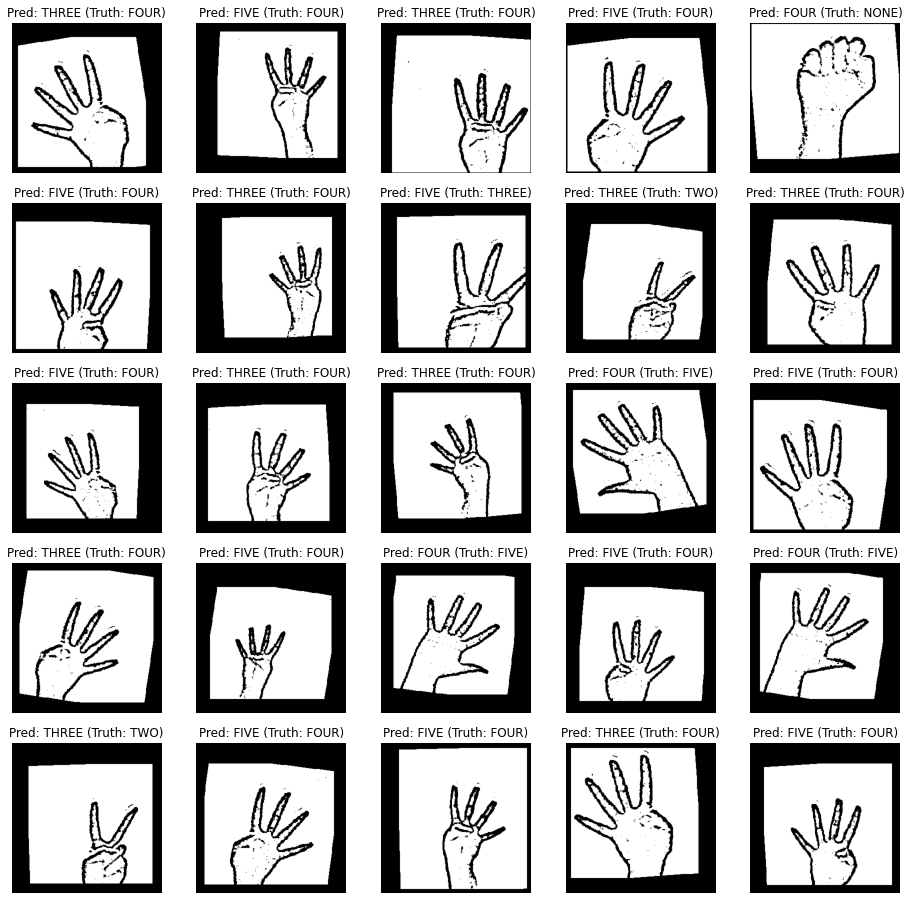

In [222]:
# display bad predictions
plt.figure(figsize=(16, 16))
for idx in range(min(25,len(incorrect_examples))):
    plt.subplot(5,5,idx+1)
    img = incorrect_examples[idx]
    plt.axis('off')
    plt.title("Pred: {} (Truth: {})".format(class_names[incorrect_preds[idx]], class_names[incorrect_target[idx]]))
    plt.imshow(img, cmap='gray')

There are a couple examples above where fingers are moved out of the frame during augmentation and the prediction is henced flawed. These issues are likely also present during training and it's hard to fault the model for getting predictions wrong in these fringe cases. 

In [21]:
# TODO: Confusion matrix - a deeper understanding than just the accuracy of each class

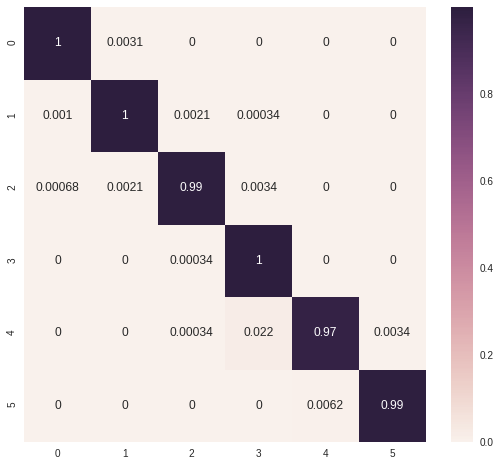

In [29]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
plt.figure(figsize=(9,8))
cm = confusion_matrix(y_test, y_pred)
cm = cm / cm.sum(axis=1)
sn.heatmap(cm, annot=True);

The confusion matrix helps summarize the cases that are misclasified as shown above. In general we see that the networks seems to usually under-count the number of fingers and this is probably at least in part to the issues in augmentation that we noted previously. The network performs quite well in general but has the most trouble counting four fingers, usually confusing it for three fingers. This issue seems most prevelant when the four fingers are quite rotated to the side. As the convolutional network is not rotation invariant, this issue could possibly be improved with more data or by adjusting the model. For the purposes of this project this issue is deemed acceptable but could be improved in the future. 